In [64]:
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
import random
from IPython.display import Audio

In [65]:
!pip install -q audiomentations


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (pyproject.toml) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


## INFO & EDA

In [66]:
genres_path = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original'
genres = os.listdir(genres_path)

for genre in genres:
    count = len(os.listdir(os.path.join(genres_path, genre)))
    print(f"{genre}: {count} tracks")

disco: 100 tracks
metal: 100 tracks
reggae: 100 tracks
blues: 100 tracks
rock: 100 tracks
classical: 100 tracks
jazz: 100 tracks
hiphop: 100 tracks
country: 100 tracks
pop: 100 tracks


/tmp/ipykernel_36/3666335376.py:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/tmp/ipykernel_36/3666335376.py:8: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(5, 2, i+1)


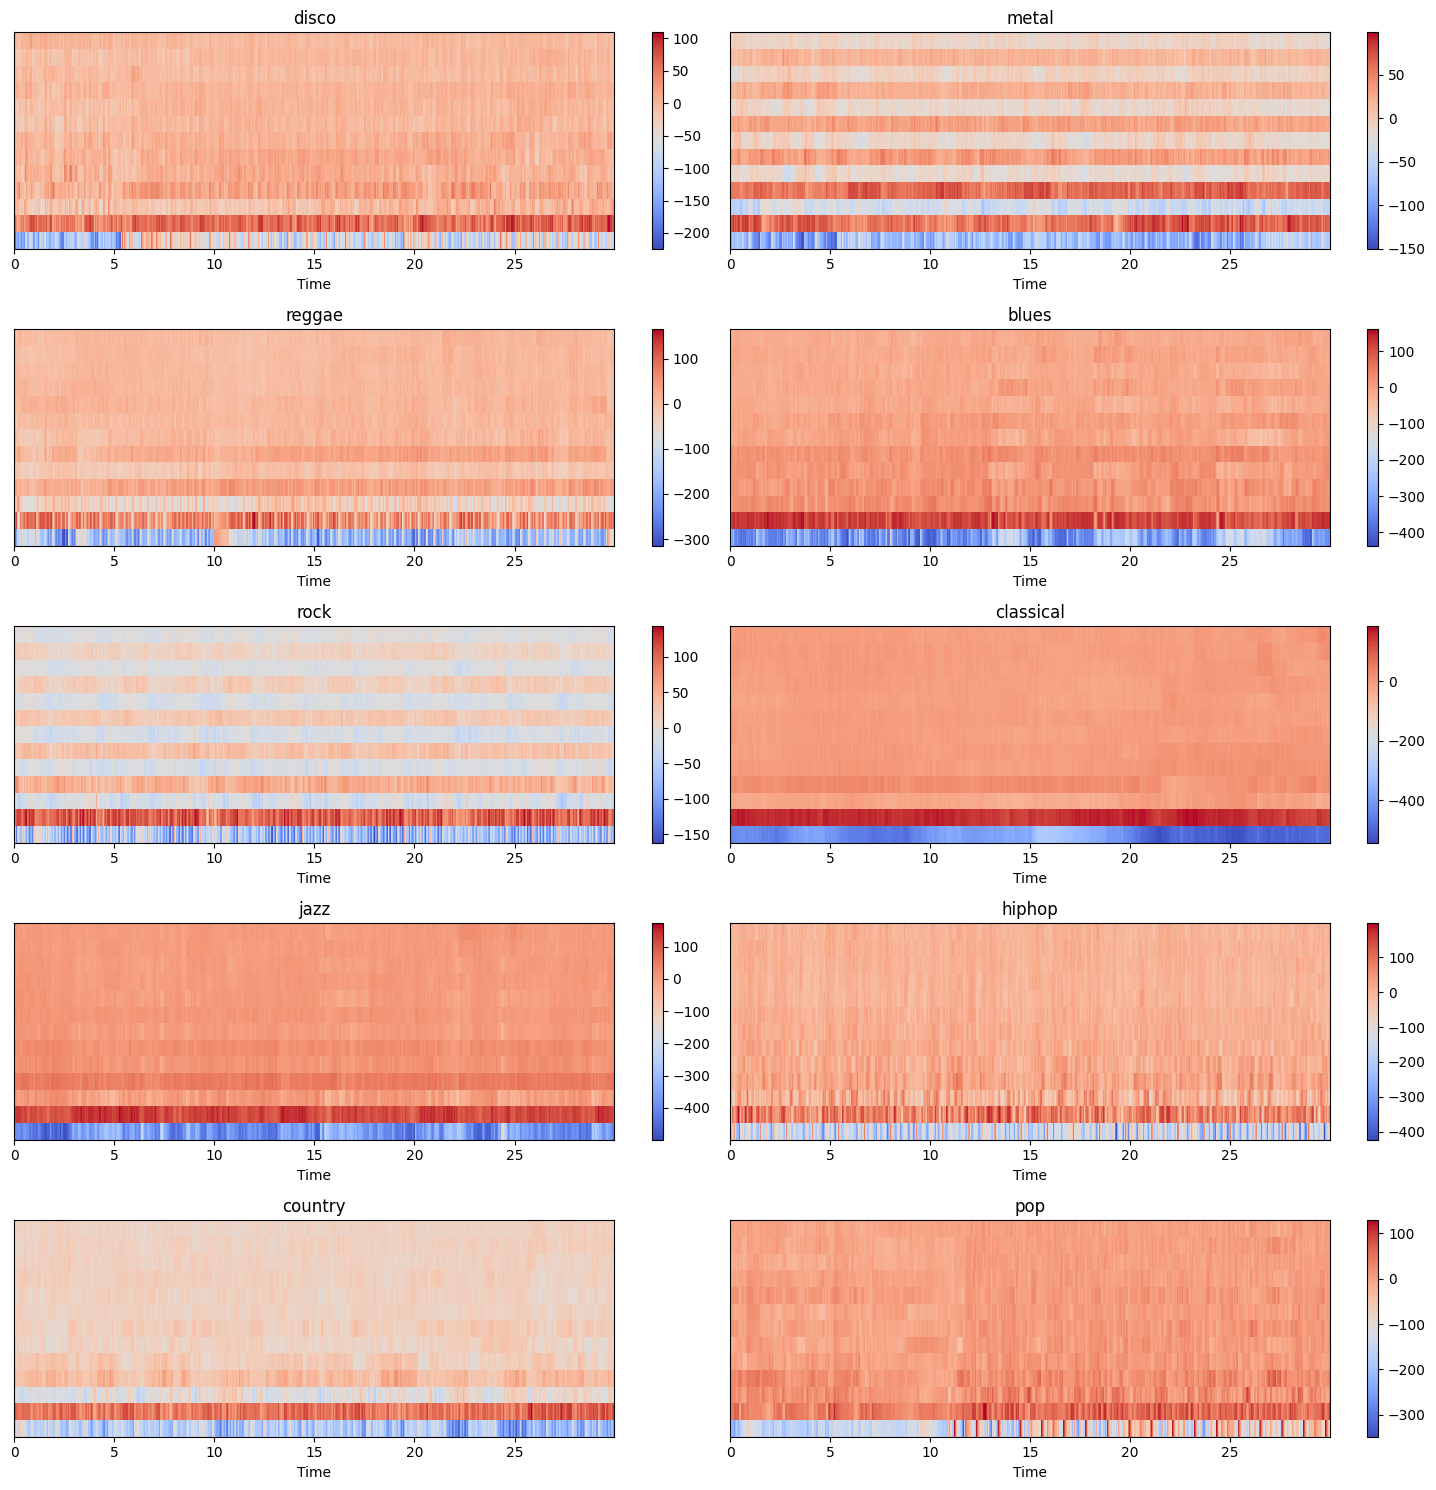

In [67]:
plt.figure(figsize=(15, 15))

for i, genre in enumerate(genres):
    file = os.path.join(genres_path, genre, os.listdir(os.path.join(genres_path, genre))[0])
    y, sr = librosa.load(file, duration=30)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.subplot(5, 2, i+1)
    librosa.display.specshow(mfcc, x_axis='time')
    plt.title(genre)
    plt.colorbar()
    plt.tight_layout()

plt.show()


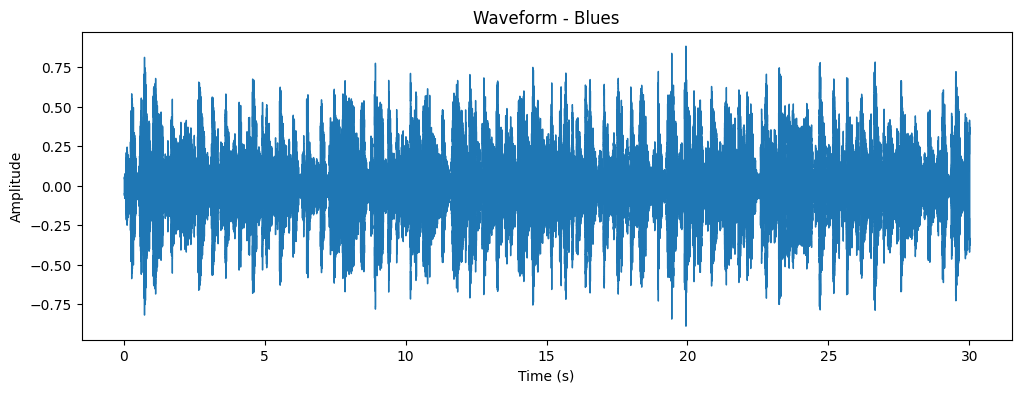

In [68]:
file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'

y, sr = librosa.load(file, duration=30)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform - Blues")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()


In [69]:
file = '/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00000.wav'
Audio(file)

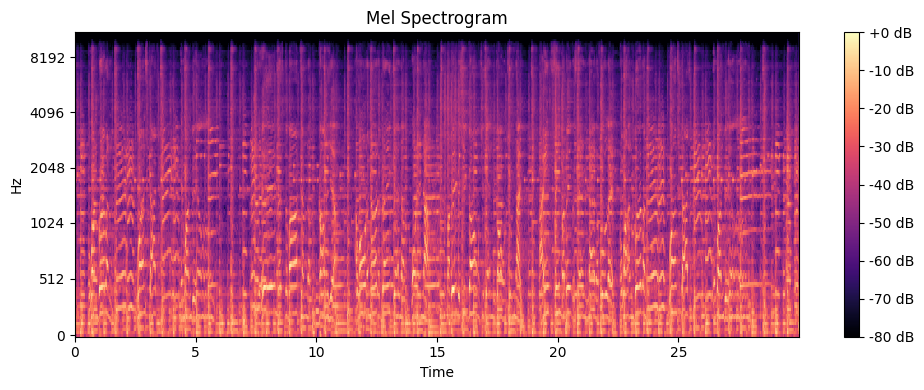

In [70]:
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.tight_layout()
plt.show()


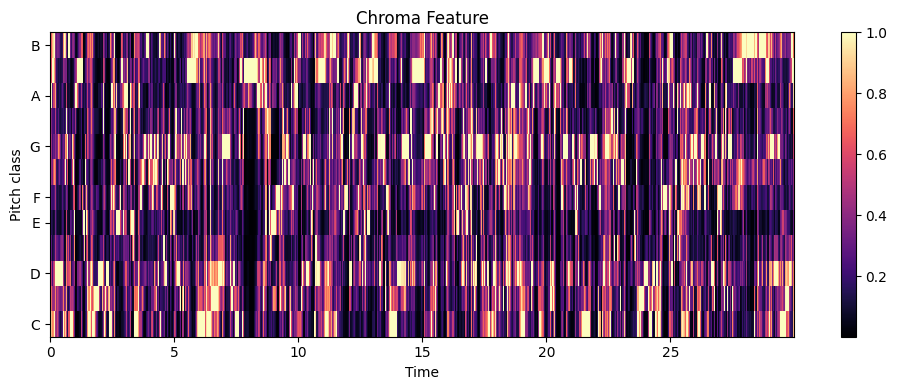

In [71]:
chroma = librosa.feature.chroma_stft(y=y, sr=sr)
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Feature')
plt.tight_layout()
plt.show()


## Loading Audio's and Creating Chunks For more data

In [72]:
def extract_chunks(file_path, chunk_duration=2, sr=22050, n_mfcc=40):
    y, _ = librosa.load(file_path, sr=sr)
    chunk_size = int(chunk_duration * sr)
    chunks = []

    for i in range(0, len(y) - chunk_size, chunk_size):
        chunk = y[i:i+chunk_size]
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=n_mfcc)
        chunks.append(mfcc.T)  # shape: (time, n_mfcc)

    return chunks

In [73]:
def extract_chunks(file_path, chunk_duration=2, sr=22050, n_mfcc=40):
    try:
        y, _ = librosa.load(file_path, sr=sr)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return []

    chunk_size = int(chunk_duration * sr)
    chunks = []

    for i in range(0, len(y) - chunk_size, chunk_size):
        chunk = y[i:i+chunk_size]
        mfcc = librosa.feature.mfcc(y=chunk, sr=sr, n_mfcc=n_mfcc)
        chunks.append(mfcc.T)

    return chunks


In [75]:
X = np.array(X)
y = np.array(y)
print(X)
print(y)

[[[-1.67944931e+02  9.06895218e+01 -8.44610023e+00 ... -1.19391880e+01
   -2.96171875e+01 -3.77911305e+00]
  [-1.43325546e+02  8.50505981e+01 -1.22608929e+01 ... -1.06923561e+01
   -1.74700203e+01 -5.35030222e+00]
  [-1.29788269e+02  6.12246475e+01  5.37331820e+00 ... -1.05551233e+01
   -7.43643522e+00 -1.30460680e+00]
  ...
  [-6.76728134e+01  1.70669918e+01 -1.92101517e+01 ...  4.55364323e+00
   -1.72549896e+01 -8.30506504e-01]
  [-6.24926643e+01  2.32373199e+01 -1.85826569e+01 ...  1.87335968e-01
   -2.62699757e+01 -6.03859568e+00]
  [-7.93088303e+01  3.87915726e+01 -1.84810658e+01 ... -7.97320318e+00
   -3.17792397e+01 -4.28483915e+00]]

 [[-6.50168610e+01  5.25314941e+01 -1.72984409e+01 ... -6.96164036e+00
   -2.48857117e+01  2.46600077e-01]
  [-5.46556282e+00  3.42953262e+01 -1.73267708e+01 ... -8.24844170e+00
   -1.53267021e+01  8.03211403e+00]
  [ 5.30203247e+00  2.19397240e+01 -2.16439705e+01 ... -7.34742498e+00
   -1.39031334e+01  9.40957928e+00]
  ...
  [-9.54628220e+01  6.1

In [76]:
import librosa.display
import matplotlib.pyplot as plt

# Visualize the first chunk
mfcc_chunk = chunks[0]  # shape: (n_mfcc, time)

plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc_chunk, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('MFCC - First Chunk')
plt.tight_layout()
plt.show()


AttributeError: 'AudioSegment' object has no attribute 'dtype'

<Figure size 1000x400 with 0 Axes>

In [77]:
for i, chunk in enumerate(chunks[:5]):
    plt.figure(figsize=(8, 3))
    librosa.display.specshow(chunk, x_axis='time')
    plt.title(f'MFCC Chunk {i+1}')
    plt.colorbar()
    plt.tight_layout()
    plt.show()


AttributeError: 'AudioSegment' object has no attribute 'dtype'

<Figure size 800x300 with 0 Axes>

In [78]:
from pydub import AudioSegment

def split_audio_chunks_pydub(file_path, chunk_duration=2000):
    audio = AudioSegment.from_file(file_path)
    chunks = []
    for i in range(0, len(audio), chunk_duration):
        chunk = audio[i:i + chunk_duration]
        if len(chunk) == chunk_duration:  # only keep full chunks
            chunks.append(chunk)
    return chunks


In [79]:
file_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00001.wav"
chunks = split_audio_chunks_pydub(file_path)

print(f"Number of 2s chunks: {len(chunks)}")


Number of 2s chunks: 15


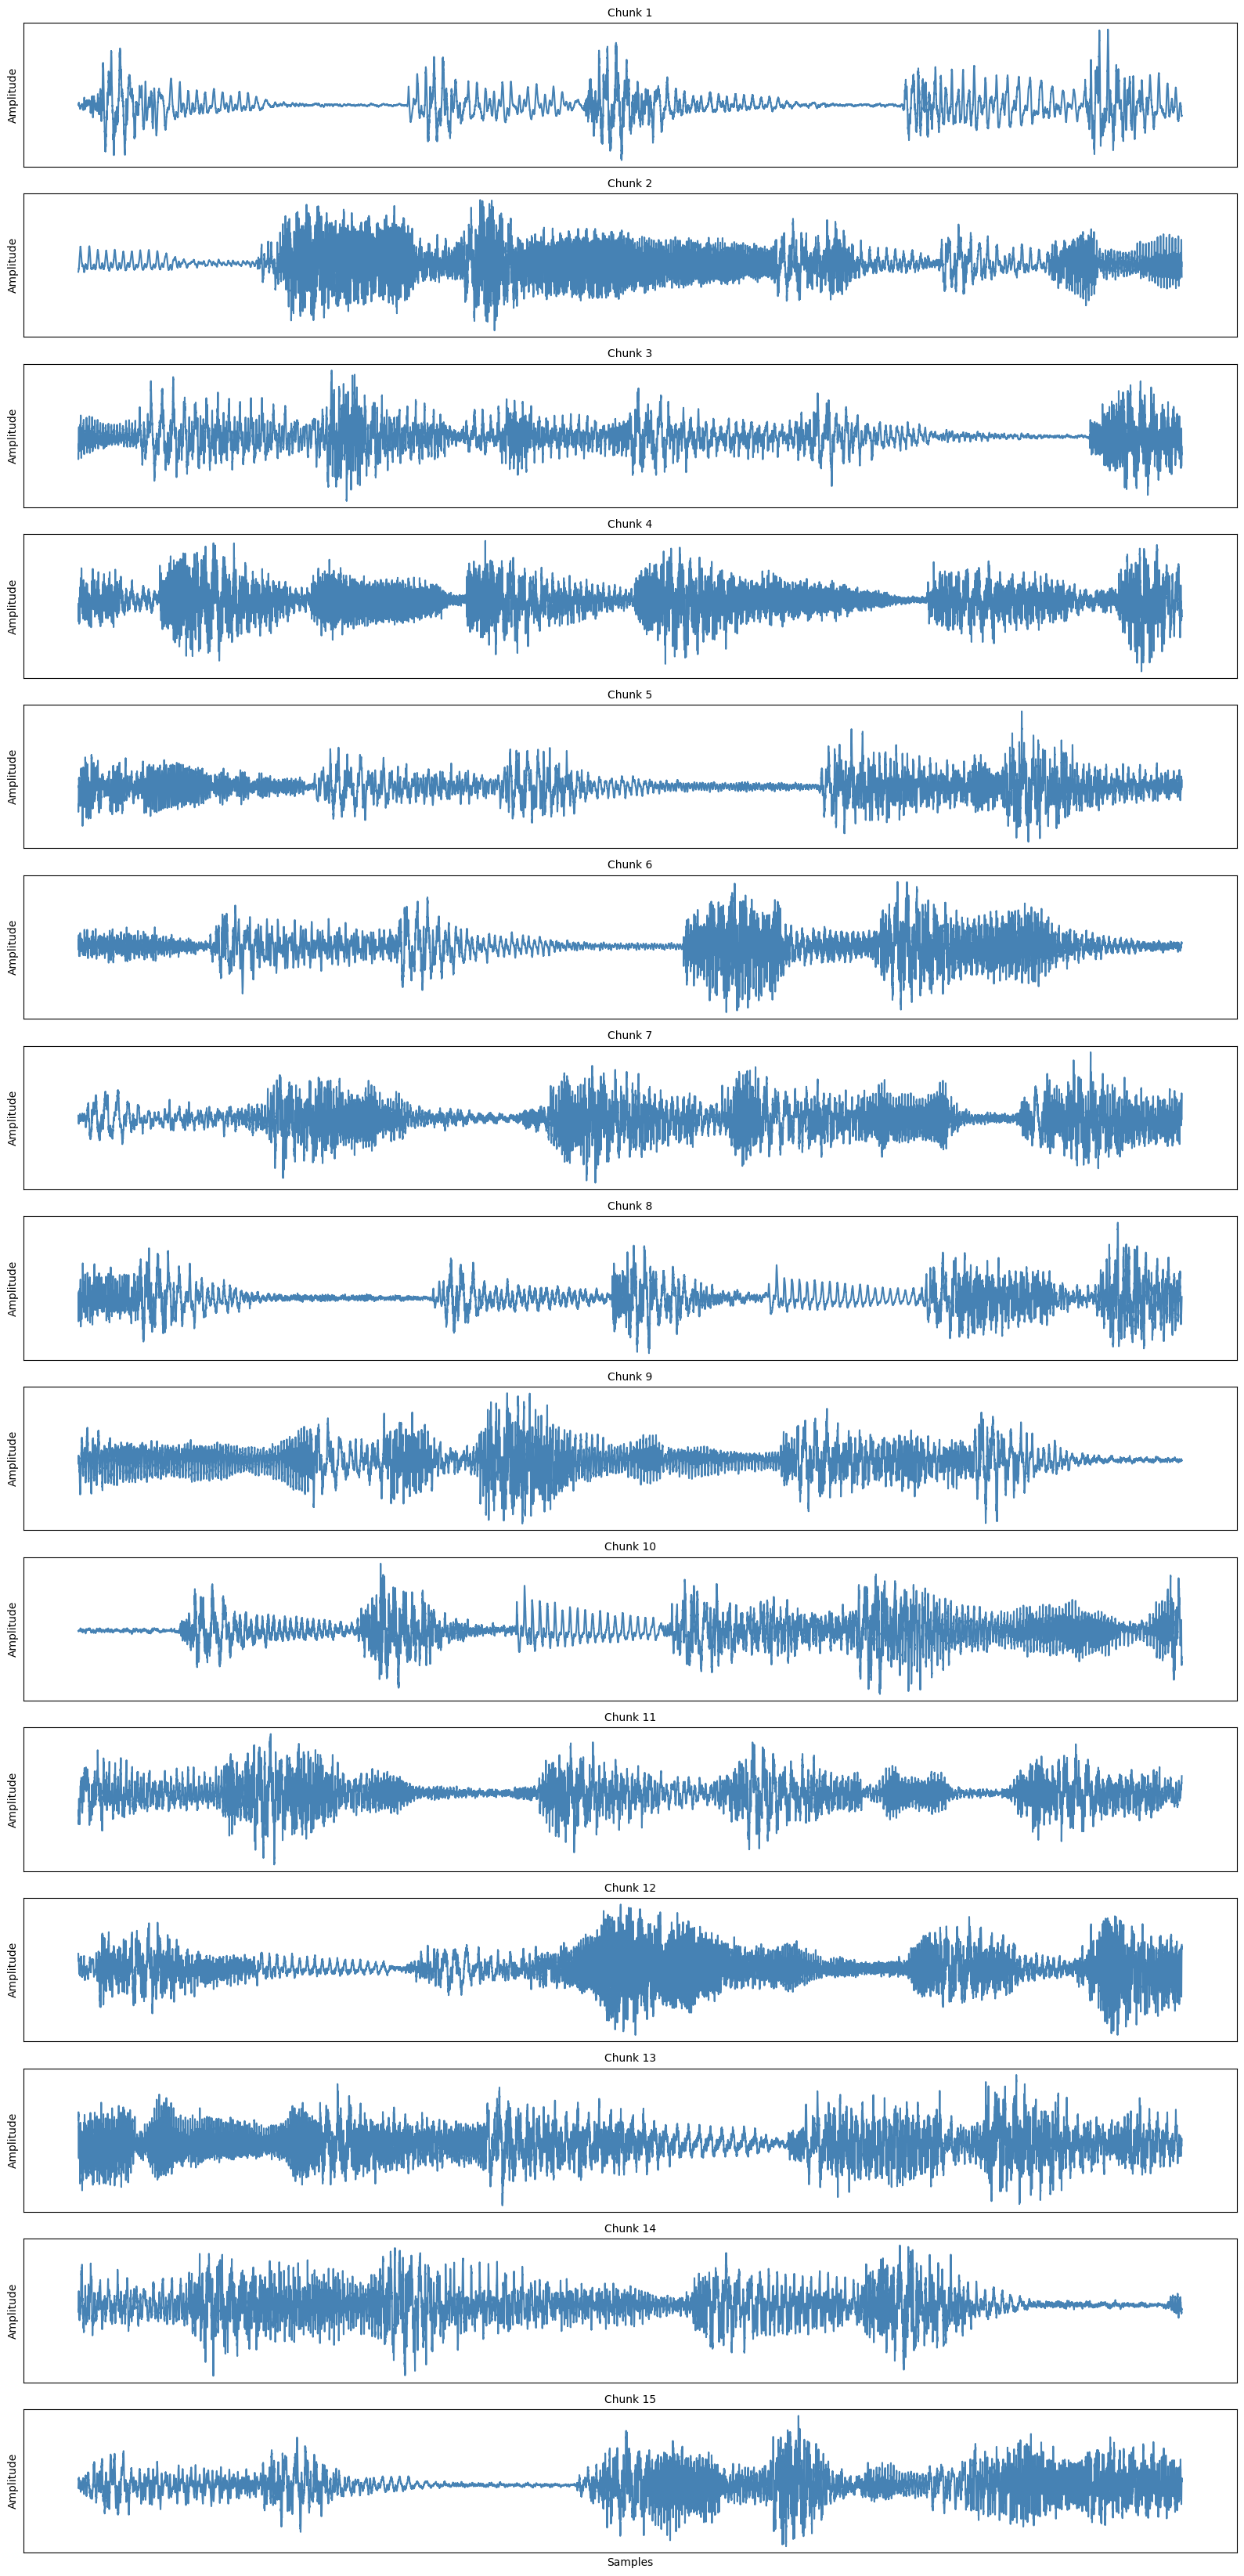

In [80]:
import matplotlib.pyplot as plt
import numpy as np
from pydub import AudioSegment

def split_audio_chunks_pydub(file_path, chunk_duration=2000):
    audio = AudioSegment.from_file(file_path)
    chunks = []
    for i in range(0, len(audio), chunk_duration):
        chunk = audio[i:i + chunk_duration]
        if len(chunk) == chunk_duration:
            chunks.append(chunk)
    return chunks

def plot_chunks_vertically(chunks):
    num_chunks = len(chunks)
    fig, axs = plt.subplots(num_chunks, 1, figsize=(16, 2.2 * num_chunks), sharex=False)

    if num_chunks == 1:
        axs = [axs]  # ensure iterable if only one chunk

    for i, chunk in enumerate(chunks):
        samples = np.array(chunk.get_array_of_samples())
        axs[i].plot(samples, color='steelblue')
        axs[i].set_title(f'Chunk {i+1}', fontsize=10)
        axs[i].set_ylabel('Amplitude')
        axs[i].set_xticks([])
        axs[i].set_yticks([])

    axs[-1].set_xlabel('Samples')
    plt.tight_layout()
    plt.show()

# Usage
file_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/blues/blues.00001.wav"
chunks = split_audio_chunks_pydub(file_path)
plot_chunks_vertically(chunks)


In [81]:
import os
from pydub import AudioSegment

base_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
chunk_duration_ms = 2000  # 2 seconds
expected_chunks_per_song = 15
total_chunks = 0
short_files = 0

def get_chunks(file_path, chunk_duration=2000):
    audio = AudioSegment.from_file(file_path)
    if len(audio) < chunk_duration * expected_chunks_per_song:
        return None  # Skip short files
    chunks = [audio[i:i+chunk_duration] for i in range(0, chunk_duration * expected_chunks_per_song, chunk_duration)]
    return chunks

for genre in os.listdir(base_path):
    genre_path = os.path.join(base_path, genre)
    if not os.path.isdir(genre_path): continue
    
    for file in os.listdir(genre_path):
        if not file.endswith(".wav"): continue
        file_path = os.path.join(genre_path, file)
        
        try:
            chunks = get_chunks(file_path)
            if chunks:
                total_chunks += len(chunks)
            else:
                short_files += 1
        except Exception as e:
            print(f"Error with file {file}: {e}")

print(f"\n✅ Total chunks created: {total_chunks}")
print(f"🟡 Skipped short files: {short_files}")


Error with file jazz.00054.wav: Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-

In [82]:
import os
import librosa
import numpy as np
from pydub import AudioSegment
from pydub.utils import make_chunks
from pydub.exceptions import CouldntDecodeError

base_path = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"

X = []
y = []

def get_chunks(file_path, chunk_duration=2000, expected_chunks=15):
    try:
        audio = AudioSegment.from_file(file_path)
        duration_seconds = len(audio) / 1000

        if duration_seconds < 4:
            return None  # too short

        if len(audio) < chunk_duration * expected_chunks:
            return None  # not enough for 15 chunks

        chunks = make_chunks(audio, chunk_duration)
        return chunks[:expected_chunks]
    except CouldntDecodeError:
        return None  # skip unreadable files

for genre in os.listdir(base_path):
    genre_path = os.path.join(base_path, genre)
    if not os.path.isdir(genre_path): continue
    
    for file in os.listdir(genre_path):
        if not file.endswith(".wav"): continue
        file_path = os.path.join(genre_path, file)
        
        chunks = get_chunks(file_path)
        if chunks is None:
            continue

        for chunk in chunks:
            samples = np.array(chunk.get_array_of_samples()).astype(np.float32)

            # Normalize
            if np.max(np.abs(samples)) == 0:
                continue
            samples /= np.max(np.abs(samples))

            # Extract MFCC
            mfcc = librosa.feature.mfcc(y=samples, sr=chunk.frame_rate, n_mfcc=13)
            mfcc = mfcc.T
            if mfcc.shape[0] >= 87:
                mfcc = mfcc[:87]
                X.append(mfcc)
                y.append(genre)

print(f"✅ Total samples: {len(X)}")
print(f"✅ Shape of one MFCC input: {X[0].shape if X else 'N/A'}")
print(f"✅ Unique genres: {set(y)}")


✅ Total samples: 14850
✅ Shape of one MFCC input: (87, 13)
✅ Unique genres: {'disco', 'reggae', 'rock', 'metal', 'classical', 'jazz', 'country', 'hiphop', 'pop', 'blues'}


In [83]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Convert to NumPy arrays
X = np.array(X)
y = np.array(y)

# Encode genre labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Optional: Save label map for later use
label_map = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label mapping:", label_map)

# Train/Val/Test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print("✅ Shapes:")
print("Train:", X_train.shape, y_train.shape)
print("Val:  ", X_val.shape, y_val.shape)
print("Test: ", X_test.shape, y_test.shape)


Label mapping: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
✅ Shapes:
Train: (11880, 87, 13) (11880,)
Val:   (1485, 87, 13) (1485,)
Test:  (1485, 87, 13) (1485,)


## Building a CNN 

In [87]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, InputLayer, Reshape
from tensorflow.keras.optimizers import Adam

model = Sequential([
    InputLayer(input_shape=(87, 13)),
    Reshape((87, 13, 1)),

    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')  # 10 genres
])

# Compile with Adam
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_2 (Reshape)             │ (None, 87, 13, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 87, 13, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 87, 13, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 43, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 43, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 43, 6, 64)      │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 43, 6, 64)      │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 21, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 21, 3, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 21, 3, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 21, 3, 128)     │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 10, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 10, 1, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 258,826 (1011.04 KB)

 Trainable params: 258,378 (1009.29 KB)

 Non-trainable params: 448 (1.75 KB)

In [88]:
history = model.fit(
    X_train_cnn, y_train_cat,
    validation_data=(X_val_cnn, y_val_cat),
    epochs=100,
    batch_size=16
)


Epoch 1/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 14s 10ms/step - accuracy: 0.2194 - loss: 2.4657 - val_accuracy: 0.4310 - val_loss: 1.6470
Epoch 2/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3450 - loss: 1.7643 - val_accuracy: 0.4539 - val_loss: 1.5222
Epoch 3/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.3974 - loss: 1.6053 - val_accuracy: 0.4451 - val_loss: 1.5172
Epoch 4/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4182 - loss: 1.5560 - val_accuracy: 0.5259 - val_loss: 1.3553
Epoch 5/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4713 - loss: 1.4272 - val_accuracy: 0.5374 - val_loss: 1.2527
Epoch 6/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4913 - loss: 1.3765 - val_accuracy: 0.5953 - val_loss: 1.1754
Epoch 7/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5220 - loss: 1.3113 - val_accuracy: 0.5374 - val_loss: 1.3778
Epoch 8/100
743/743 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5623 - loss: 1.2470 - val_ac

In [89]:
test_loss, test_acc = model.evaluate(X_test_cnn, y_test_cat)
print(f"Test Accuracy: {test_acc:.4f}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8681 - loss: 0.4607
Test Accuracy: 0.8700
